In [44]:
####################################################################################################
# Abe Tishelman-Charny
# abraham.tishelman.charny@cern.ch
# 16 April 2020
#
# The purpose of this module is to create 10x10 arrays of photon rec hit images 
# for prompt and fake photons in order to feed into a CNN. 
# This module also trains the CNN with prompt and fake images and outputs signal and fake efficiencies.

# Thank you: 
# https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
#####################################################################################################

# !pip install --user uproot # shouldn't be necessary 

##-- Imports 

import ROOT
from ROOT import TFile, gROOT
import numpy as np 
import uproot

gROOT.SetBatch(1)

In [45]:
##-- Params for running through output ntuples from flashgg event dumper

########################################################################################################
input_file = "/eos/user/a/atishelm/ntuples/PhotonCNN/20-40CheckDetID_Hadded/20-40_Hadded.root"
width = 10 # width of recHit window
maxPhotons = 1000 # Number of photons to run over for each tree: Prompt and Fake. -1 for all photons  
doPrompts = 1
doFakes = 1
plotFullMaps = 1 # make plots of total energy and occupancy for EB, EE for Prompts and Fakes
TrainPct = 0.675 # Percentage of events used for training (applied to both prompts and fakes)
ValidPct = 0.225 # Percentage of events used for validation (applied to both prompts and fakes)
# remaining events are used for testing 
printPct = 50 # Print progress for rec hit every printPct percent 
########################################################################################################    

f = TFile(input_file)
Prompt_t = f.Get("photonViewDumper/trees/promptPhotons") 
Fake_t = f.Get("photonViewDumper/trees/fakePhotons") 

Pct1 = TrainPct 
Pct2 = ValidPct + Pct1 

X_train_EB = []
Y_train_EB = []

X_valid_EB = []
Y_valid_EB = []

X_test_EB_Prompts = []
Y_test_EB_Prompts = [] 
X_test_EB_Fakes = []
Y_test_EB_Fakes = [] 

X_train_EE = []
Y_train_EE = []

X_valid_EE = []
Y_valid_EE = []

X_test_EE_Prompts = []
Y_test_EE_Prompts = [] 
X_test_EE_Fakes = []
Y_test_EE_Fakes = [] 

EB_width = 170 # ieta: -85 to 85 
EB_height = 360 # iphi: 0 to 360 

EE_width = 100 # ix: 0-100
EE_height = 100 # iy: 0-100

FullMap_SigEB_rechits = [ [ 0 for i in range(EB_height) ] for j in range(EB_width) ]
FullMap_NSigEB_rechits = [ [ 0 for i in range(EB_height) ] for j in range(EB_width) ]

FullMap_FakeEB_rechits = [ [ 0 for i in range(EB_height) ] for j in range(EB_width) ]
FullMap_NFakeEB_rechits = [ [ 0 for i in range(EB_height) ] for j in range(EB_width) ]

FullMap_SigEE_rechits = [ [ 0 for i in range(EE_height) ] for j in range(EE_width) ]
FullMap_NSigEE_rechits = [ [ 0 for i in range(EE_height) ] for j in range(EE_width) ]

FullMap_FakeEE_rechits = [ [ 0 for i in range(EE_height) ] for j in range(EE_width) ]
FullMap_NFakeEE_rechits = [ [ 0 for i in range(EE_height) ] for j in range(EE_width) ]

BadDOF3RawIds = open("BadDOF3RawIds.txt","w") 
BadrelDOFRawIds = open("BadrelDOFRawIds.txt","w")

##-- Get num rec hits and names of branches to use 

num_rec_hits = int(float(width)*float(width))

DOF1s, DOF2s, DOF3s, irechitEs = [], [], [], []

for i in range(int(num_rec_hits)):
    tmp_name = "DOF1s_"
    tmp_name += str(i)
    DOF1s.append(tmp_name)

    tmp_name = "DOF2s_"
    tmp_name += str(i)
    DOF2s.append(tmp_name)

    tmp_name = "DOF3s_"
    tmp_name += str(i)
    DOF3s.append(tmp_name)

    tmp_name = "recHit_"
    tmp_name += str(i)
    irechitEs.append(tmp_name)

nPromptPhotons, nFakePhotons = Prompt_t.GetEntries(), Fake_t.GetEntries()

print('Number of prompt photons in file:', nPromptPhotons)
print('Number of fake photons in file:', nFakePhotons)

##-- Run on all photons, unless specified 
if(maxPhotons==-1):
    PromptPhotonstoRun = nPromptPhotons
    FakePhotonstoRun = nFakePhotons
else:
    PromptPhotonstoRun = maxPhotons 
    FakePhotonstoRun = maxPhotons

print('Running on %s prompt photons'%PromptPhotonstoRun)    
print('Running on %s fake photons'%FakePhotonstoRun)    
    
print('Opening file...')
file = uproot.open(input_file)
print('Opened file: %s'%input_file)

if(doPrompts):
    promptTree = file['photonViewDumper/trees/promptPhotons']
    print('Reading branch info...')
    promptBranches = promptTree.arrays(namedecode='utf-8')
    print('Got branch info!')

    promptPhoObjDOF1Vals = promptBranches["DOF1"]
    promptPhoObjDOF2Vals = promptBranches["DOF2"]
    promptPhoObjDOF3Vals = promptBranches["DOF3"]

    ##-- Prompts     
    # initialize an array for each photon 
    # loop rec hits 
    # for each rec hit, fill appropriate array spot for all photons 
    # append all arrays to train, validate, or test data::: sort based on EB,EE

    # Create array for each photon 
    allPromptImages = []
    allPromptImagesDOF3 = []
    for iPho in range(PromptPhotonstoRun): #### make sure this is set properly.......
        allPromptImages.append( 
                [ [ 0 for i in range(width) ] for j in range(width) ]
            )
        allPromptImagesDOF3.append(-99)

    for i_recHit in range(0,num_rec_hits):
        if(i_recHit%10 == 0): print('On rechit: %s/%s'%(str(i_recHit),str(num_rec_hits)))
        DOF1BranchName = DOF1s[i_recHit]
        DOF2BranchName = DOF2s[i_recHit]
        DOF3BranchName = DOF3s[i_recHit]
        recHitBranchName = irechitEs[i_recHit]
        recHitRawIdName = "rawId_%s"%(str(i_recHit))

        DOF1Vals = promptBranches[DOF1BranchName]
        DOF2Vals = promptBranches[DOF2BranchName]
        DOF3Vals = promptBranches[DOF3BranchName]
        recHitVals = promptBranches[recHitBranchName]
        recHitRawIdVals = promptBranches[recHitRawIdName]

        for iPho in range(0,PromptPhotonstoRun):
            if(iPho%float(PromptPhotonstoRun/(100./printPct)) == 0): print('[ %s %% ] --- On Prompt Photon %s/%s'%(str(float(iPho)*100./float(PromptPhotonstoRun)),str(iPho),str(PromptPhotonstoRun)))                
            recHitDOF1 = DOF1Vals[iPho]
            recHitDOF2 = DOF2Vals[iPho]
            recHitDOF3 = DOF3Vals[iPho]
            recHitVal = recHitVals[iPho]
            promptPhoDOF1 = promptPhoObjDOF1Vals[iPho]
            promptPhoDOF2 = promptPhoObjDOF2Vals[iPho]
            promptPhoDOF3 = promptPhoObjDOF3Vals[iPho]

            if(recHitDOF1 == -9999): continue 

            rel_dof1 = int((recHitDOF1 - promptPhoDOF1)) + 4 
            rel_dof2 = int((recHitDOF2 - promptPhoDOF2)) + 4  

            if(recHitDOF3!=0 and recHitDOF3!=-1 and recHitDOF3!=1 and recHitDOF3!=-9999): 
                RawId = recHitRawIdVals[iPho]
                BadDOF3RawIds.write("%s\n"%(str(RawId)))
                continue 

            if(rel_dof2 < 0) or (rel_dof1 < 0) or (rel_dof2 >= 10) or (rel_dof1 >= 10):
                RawId = recHitRawIdVals[iPho]
                BadrelDOFRawIds.write("%s\n"%(str(RawId))) 
                continue                 

            allPromptImages[iPho][rel_dof1][rel_dof2] += recHitVal # update each Photon's i_recHit 
            if(allPromptImagesDOF3[iPho]==-99): allPromptImagesDOF3[iPho] = promptPhoDOF3
            if(plotFullMaps):
                if(promptPhoDOF3 == 0):
                    FullMap_SigEB_rechits[int(recHitDOF1)+84][int(recHitDOF2)-1] += recHitVal
                    FullMap_NSigEB_rechits[int(recHitDOF1)+84][int(recHitDOF2)-1] += 1
                else:
                    FullMap_SigEE_rechits[int(recHitDOF1)-1][int(recHitDOF2)-1] += recHitVal
                    FullMap_NSigEE_rechits[int(recHitDOF1)-1][int(recHitDOF2)-1] += 1                
         
    ##-- Distribute images among Training, Validation and Test datasets                                     
    for img_i,image in enumerate(allPromptImages):
        imgDOF3 = allPromptImagesDOF3[img_i]

        # EB 
        if imgDOF3 == 0:
            if(img_i < Pct1*PromptPhotonstoRun):
                X_train_EB.append(image)
                Y_train_EB.append(1) # 1 = signal 
#                 Y_train_EB.append([1,0]) # 1 = signal 
            elif( (img_i > Pct1*PromptPhotonstoRun) and (img_i <= Pct2*PromptPhotonstoRun) ):
                X_valid_EB.append(image)
                Y_valid_EB.append(1)
#                 Y_valid_EB.append([1,0])
            else:
                X_test_EB_Prompts.append(image)
                Y_test_EB_Prompts.append(1)
#                 Y_test_EB_Prompts.append([1,0])

        # EE
        elif imgDOF3 == -1 or imgDOF3 == 1:
            if(img_i < Pct1*PromptPhotonstoRun):
                X_train_EE.append(image)
                Y_train_EE.append(1) # 1 = signal 
            elif( (img_i > Pct1*PromptPhotonstoRun) and (img_i <= Pct2*PromptPhotonstoRun) ):
                X_valid_EE.append(image)
                Y_valid_EE.append(1)
            else:
                X_test_EE_Prompts.append(image)
                Y_test_EE_Prompts.append(1)

        else:
            print('ERROR')
            print('image DOF3 is neither EB nor EE.')
            print('Exiting')
            exit(0)


if(doFakes):
    #####
    # Fakes
    print('On Fakes')

    fakeTree = file['photonViewDumper/trees/fakePhotons']
    print("Reading branch info...")
    fakeBranches = fakeTree.arrays(namedecode='utf-8')
    print("Got branch info!")
    fakePhoObjDOF1Vals = fakeBranches["DOF1"]
    fakePhoObjDOF2Vals = fakeBranches["DOF2"]
    fakePhoObjDOF3Vals = fakeBranches["DOF3"]

    # Create array for each Photon
    allFakeImages = []
    allFakeImagesDOF3 = []
    for iPho in range(FakePhotonstoRun):
        allFakeImages.append(
                [ [ 0 for i in range(width) ] for j in range(width) ]
            )
        allFakeImagesDOF3.append(-99)

    for i_recHit in range(0,num_rec_hits):
        if(i_recHit%10 == 0): print('On rechit: %s/%s'%(str(i_recHit),str(num_rec_hits)))
        DOF1BranchName = DOF1s[i_recHit]
        DOF2BranchName = DOF2s[i_recHit]
        DOF3BranchName = DOF3s[i_recHit]
        recHitBranchName = irechitEs[i_recHit]
        recHitRawIdName = "rawId_%s"%(str(i_recHit))

        DOF1Vals = fakeBranches[DOF1BranchName]
        DOF2Vals = fakeBranches[DOF2BranchName]
        DOF3Vals = fakeBranches[DOF3BranchName]
        recHitVals = fakeBranches[recHitBranchName]
        recHitRawIdVals = fakeBranches[recHitRawIdName]

        for iPho in range(FakePhotonstoRun):
            if(iPho%float(FakePhotonstoRun/(100./printPct)) == 0): print('[ %s %% ] --- On Fake Photon: %s/%s'%(str(float(iPho)*100./float(FakePhotonstoRun)),str(iPho),str(FakePhotonstoRun)))
            recHitDOF1 = DOF1Vals[iPho]
            recHitDOF2 = DOF2Vals[iPho]
            recHitDOF3 = DOF3Vals[iPho]
            recHitVal = recHitVals[iPho]
            fakePhoDOF1 = fakePhoObjDOF1Vals[iPho]
            fakePhoDOF2 = fakePhoObjDOF2Vals[iPho]
            fakePhoDOF3 = fakePhoObjDOF3Vals[iPho]

            if(recHitDOF1 == -9999): continue # in this case,

            rel_dof1 = int(recHitDOF1 - fakePhoDOF1) + 4 
            rel_dof2 = int(recHitDOF2 - fakePhoDOF2) + 4 

            if(recHitDOF3!=0 and recHitDOF3!=-1 and recHitDOF3!=1 and recHitDOF3!=-9999): 
                RawId = recHitRawIdVals[iPho]
                BadDOF3RawIds.write("%s\n"%(str(RawId)))
                continue 

            if(rel_dof2 < 0) or (rel_dof1 < 0) or (rel_dof2 >= 10) or (rel_dof1 >= 10):
                RawId = recHitRawIdVals[iPho]
                BadrelDOFRawIds.write("%s\n"%(str(RawId))) 
                continue  

            allFakeImages[iPho][rel_dof1][rel_dof2] += recHitVal # update each event's i_recHit 
            if(allFakeImagesDOF3[iPho]==-99): allFakeImagesDOF3[iPho] = fakePhoDOF3
            if(plotFullMaps):
#                 print("int(recHitDOF1):",int(recHitDOF1))
#                 print("int(recHitDOF2):",int(recHitDOF2))
                if(fakePhoDOF3 == 0):
                    FullMap_FakeEB_rechits[int(recHitDOF1)+84][int(recHitDOF2)-1] += recHitVal
                    FullMap_NFakeEB_rechits[int(recHitDOF1)+84][int(recHitDOF2)-1] += 1
                else:
#                     print("promptPhoDOF3:",promptPhoDOF3)
                    if(int(recHitDOF1)>100) or int(recHitDOF2>100):
                        print("For some reason, DOF3 is not 0, but DOF1 or 2 is greater than 100...")
                        print("Skipping for now, but this needs to be understood")
#                         print("int(recHitDOF1):",int(recHitDOF1))
#                         print("int(recHitDOF2):",int(recHitDOF2))
                        continue
                    FullMap_FakeEE_rechits[int(recHitDOF1)-1][int(recHitDOF2)-1] += recHitVal
                    FullMap_NFakeEE_rechits[int(recHitDOF1)-1][int(recHitDOF2)-1] += 1             
            

    ##-- Distribute images among Training, Validation and Test datasets 
    for img_i,image in enumerate(allFakeImages):
        imgDOF3 = allFakeImagesDOF3[img_i]

        # EB 
        if imgDOF3 == 0:
            if(img_i < Pct1*FakePhotonstoRun):
                X_train_EB.append(image)
                Y_train_EB.append(0) # 1 = signal 
#                 Y_train_EB.append([0,1]) # 1 = signal 
            elif( (img_i > Pct1*FakePhotonstoRun) and (img_i <= Pct2*FakePhotonstoRun) ):
                X_valid_EB.append(image)
                Y_valid_EB.append(0)
#                 Y_valid_EB.append([0,1])
            else:
                X_test_EB_Fakes.append(image)
                Y_test_EB_Fakes.append(0)
#                 Y_test_EB_Fakes.append([0,1])

        # EE
        elif imgDOF3 == -1 or imgDOF3 == 1:
            if(img_i < Pct1*FakePhotonstoRun):
                X_train_EE.append(image)
                Y_train_EE.append(0) # 1 = signal 
#                 Y_train_EE.append([0,1]) # 1 = signal 
            elif( (img_i > Pct1*FakePhotonstoRun) and (img_i <= Pct2*FakePhotonstoRun) ):
                X_valid_EE.append(image)
                Y_valid_EE.append(0)
#                 Y_valid_EE.append([0,1])
            else:
                X_test_EE_Fakes.append(image)
                Y_test_EE_Fakes.append(0)
#                 Y_test_EE_Fakes.append([0,1])

        else:
            print('ERROR')
            print('image DOF3 is neither EB nor EE.')
            print('Exiting')
            exit(0)
   
 
BadDOF3RawIds.close()
BadrelDOFRawIds.close()


print('DONE')

Number of prompt photons in file: 488383
Number of fake photons in file: 378409
Running on 1000 prompt photons
Running on 1000 fake photons
Opening file...
Opened file: /eos/user/a/atishelm/ntuples/PhotonCNN/20-40CheckDetID_Hadded/20-40_Hadded.root
Reading branch info...
Got branch info!
On rechit: 0/100
[ 0.0 % ] --- On Prompt Photon 0/1000
[ 50.0 % ] --- On Prompt Photon 500/1000
[ 0.0 % ] --- On Prompt Photon 0/1000
[ 50.0 % ] --- On Prompt Photon 500/1000
[ 0.0 % ] --- On Prompt Photon 0/1000
[ 50.0 % ] --- On Prompt Photon 500/1000
[ 0.0 % ] --- On Prompt Photon 0/1000
[ 50.0 % ] --- On Prompt Photon 500/1000
[ 0.0 % ] --- On Prompt Photon 0/1000
[ 50.0 % ] --- On Prompt Photon 500/1000
[ 0.0 % ] --- On Prompt Photon 0/1000
[ 50.0 % ] --- On Prompt Photon 500/1000
[ 0.0 % ] --- On Prompt Photon 0/1000
[ 50.0 % ] --- On Prompt Photon 500/1000
[ 0.0 % ] --- On Prompt Photon 0/1000
[ 50.0 % ] --- On Prompt Photon 500/1000
[ 0.0 % ] --- On Prompt Photon 0/1000
[ 50.0 % ] --- On Prompt

Reading branch info...
Got branch info!
On rechit: 0/100
[ 0.0 % ] --- On Fake Photon: 0/1000
[ 50.0 % ] --- On Fake Photon: 500/1000
[ 0.0 % ] --- On Fake Photon: 0/1000
[ 50.0 % ] --- On Fake Photon: 500/1000
[ 0.0 % ] --- On Fake Photon: 0/1000
[ 50.0 % ] --- On Fake Photon: 500/1000
[ 0.0 % ] --- On Fake Photon: 0/1000
[ 50.0 % ] --- On Fake Photon: 500/1000
[ 0.0 % ] --- On Fake Photon: 0/1000
[ 50.0 % ] --- On Fake Photon: 500/1000
[ 0.0 % ] --- On Fake Photon: 0/1000
[ 50.0 % ] --- On Fake Photon: 500/1000
[ 0.0 % ] --- On Fake Photon: 0/1000
[ 50.0 % ] --- On Fake Photon: 500/1000
[ 0.0 % ] --- On Fake Photon: 0/1000
[ 50.0 % ] --- On Fake Photon: 500/1000
[ 0.0 % ] --- On Fake Photon: 0/1000
[ 50.0 % ] --- On Fake Photon: 500/1000
[ 0.0 % ] --- On Fake Photon: 0/1000
[ 50.0 % ] --- On Fake Photon: 500/1000
On rechit: 10/100
[ 0.0 % ] --- On Fake Photon: 0/1000
[ 50.0 % ] --- On Fake Photon: 500/1000
[ 0.0 % ] --- On Fake Photon: 0/1000
[ 50.0 % ] --- On Fake Photon: 500/1000
[

In [46]:
##-- Turn images, stored in python lists, into numpy arrays

##-- Options
####################################
printLengths = 1 # print lengths of X/Y, train/valid/test, EB/EE sets 
printArrays = 0 # print values of X/Y, train/valid/test, EB/EE sets (warning: very large output for many events!)
####################################

# Names before making np.arrays:
# X/Y_train/valid/test_EB/EE

# Names after making np.arrays:
# X/Y_train/valid/test_EB/EE_arr

X_train_EB_arr = np.array(X_train_EB)
X_valid_EB_arr = np.array(X_valid_EB)

Y_train_EB_arr = np.array(Y_train_EB)
Y_valid_EB_arr = np.array(Y_valid_EB)

X_test_EB_Prompts_arr = np.array(X_test_EB_Prompts)
Y_test_EB_Prompts_arr = np.array(Y_test_EB_Prompts)

X_test_EB_Fakes_arr = np.array(X_test_EB_Fakes)
Y_test_EB_Fakes_arr = np.array(Y_test_EB_Fakes)

X_train_EE_arr = np.array(X_train_EE)
X_valid_EE_arr = np.array(X_valid_EE)

Y_train_EE_arr = np.array(Y_train_EE)
Y_valid_EE_arr = np.array(Y_valid_EE)

X_test_EE_Prompts_arr = np.array(X_test_EE_Prompts)
Y_test_EE_Prompts_arr = np.array(Y_test_EE_Prompts)

X_test_EE_Fakes_arr = np.array(X_test_EE_Fakes)
Y_test_EE_Fakes_arr = np.array(Y_test_EE_Fakes)

if(printLengths):
    print('len(X_train_EB_arr) = ',len(X_train_EB_arr))
    print('len(X_valid_EB_arr) = ',len(X_valid_EB_arr))
    print('len(X_test_EB_Prompts_arr) = ',len(X_test_EB_Prompts_arr))
    print('len(X_test_EB_Fakes_arr) = ',len(X_test_EB_Fakes_arr))
    print('len(X_train_EE_arr) = ',len(X_train_EE_arr))
    print('len(X_valid_EE_arr) = ',len(X_valid_EE_arr))
    print('len(X_test_EE_Prompts_arr) = ',len(X_test_EE_Prompts_arr))
    print('len(X_test_EE_Fakes_arr) = ',len(X_test_EE_Fakes_arr))
    EB_sum = len(X_train_EB_arr) + len(X_valid_EB_arr) + len(X_test_EB_Prompts_arr) + len(X_test_EB_Fakes_arr)
    EE_sum = len(X_train_EE_arr) + len(X_valid_EE_arr) + len(X_test_EE_Prompts_arr) + len(X_test_EE_Fakes_arr)
    print('EB sum: ',EB_sum)
    print('EE sum: ',EE_sum)
    outputTotal = EB_sum + EE_sum
    print('outputTotal:',outputTotal )
    print('-----')
    print('n prompt photons:', nPromptPhotons)
    print('n fake photons:', nFakePhotons)
    treeTotal = nPromptPhotons + nFakePhotons
    print('Tree Total:',treeTotal)
    
    ##-- If running over all photons, check that all events were placed into Prompt/Fake, EB/EE, Train/Valid/Test categories.
    if(maxPhotons == -1): assert(treeTotal==outputTotal) 

if(printArrays):
    print('Y_train_EB_arr = ',Y_train_EB_arr)
    print('Y_valid_EB_arr = ',Y_valid_EB_arr)
    print('Y_test_EB_Prompts_arr = ',Y_test_EB_Prompts_arr)
    print('Y_test_EB_Fakes_arr = ',Y_test_EB_Fakes_arr)
    
    print('Y_train_EE_arr = ',Y_train_EE_arr)
    print('Y_valid_EE_arr = ',Y_valid_EE_arr)
    print('Y_test_EE_Prompts_arr = ',Y_test_EE_Prompts_arr)
    print('Y_test_EE_Fakes_arr = ',Y_test_EE_Fakes_arr)    
    

len(X_train_EB_arr) =  746
len(X_valid_EB_arr) =  247
len(X_test_EB_Prompts_arr) =  50
len(X_test_EB_Fakes_arr) =  64
len(X_train_EE_arr) =  604
len(X_valid_EE_arr) =  203
len(X_test_EE_Prompts_arr) =  50
len(X_test_EE_Fakes_arr) =  36
EB sum:  1107
EE sum:  893
outputTotal: 2000
-----
n prompt photons: 488383
n fake photons: 378409
Tree Total: 866792


In [47]:
##-- Plot average rec hit image EB, EE, Prompt, Fake

##-- Options
####################################
plotRelMaps = 1 # make plots of total energy and occupancy for EB, EE for Prompts and Fakes 
output_path = "/eos/user/<letter>/<lxplusName>/www/<outFolder>/" # Output location for plots 
####################################

if(plotRelMaps or plotFullMaps):

    ROOT.gROOT.SetBatch(1) # Do not plot upon draw statement 
    ROOT.gStyle.SetOptStat(0)

    def DrawSave(h_tmp, name, output_path_):
        c1 = ROOT.TCanvas()
        h_tmp.Draw("COLZ1")
        # h_tmp.GetZaxis().SetRangeUser(0,)
        c1.SaveAs(output_path_ + name)
        h_tmp.SaveAs(output_path_ + name[:-4] + ".root")

    if(plotRelMaps):
        width_i = int(width)
        Avg_sigRecHitMapEB = ROOT.TH2F("Avg_sigRecHitMapEB","Avg_sigRecHitMapEB",width_i,0,width,width_i,0,width)  
        Avg_sigRecHitMapEB.GetXaxis().SetTitle("i#eta");  
        Avg_sigRecHitMapEB.GetYaxis().SetTitle("i#phi")

        Avg_FakeRecHitMapEB = ROOT.TH2F("Avg_FakeRecHitMapEB","Avg_FakeRecHitMapEB",width_i,0,width,width_i,0,width)  
        Avg_FakeRecHitMapEB.GetXaxis().SetTitle("i#eta");  
        Avg_FakeRecHitMapEB.GetYaxis().SetTitle("i#phi")

        Avg_sigRecHitMapEE = ROOT.TH2F("Avg_sigRecHitMapEE","Avg_sigRecHitMapEE",width_i,0,width,width_i,0,width)  
        Avg_sigRecHitMapEE.GetXaxis().SetTitle("ix");  
        Avg_sigRecHitMapEE.GetYaxis().SetTitle("iy")

        Avg_FakeRecHitMapEE = ROOT.TH2F("Avg_FakeRecHitMapEE","Avg_FakeRecHitMapEE",width_i,0,width,width_i,0,width)  
        Avg_FakeRecHitMapEE.GetXaxis().SetTitle("ix");  
        Avg_FakeRecHitMapEE.GetYaxis().SetTitle("iy")

        SigEB_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]
        NSigEB_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]
        AvgSigEB_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]

        FakeEB_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]
        NFakeEB_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]
        AvgFakeEB_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]

        SigEE_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]
        NSigEE_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]
        AvgSigEE_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]

        FakeEE_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]
        NFakeEE_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]
        AvgFakeEE_rechits = [ [ 0 for i in range(width_i) ] for j in range(width_i) ]

        ##-- EB 
        print("On avg EB hits...")
        for i,image in enumerate(X_train_EB):
            for x in range(0,width_i):
                for y in range(0,width_i):
                    recHitE = image[x][y]
                    if(recHitE != 0) and (Y_train_EB[i] == 1): # prompt
                        SigEB_rechits[x][y] += recHitE  
                        NSigEB_rechits[x][y] += 1 
                    elif(recHitE != 0) and (Y_train_EB[i] == 0): # fake
                        FakeEB_rechits[x][y] += recHitE  
                        NFakeEB_rechits[x][y] += 1             

        for x in range(0,width_i):
            for y in range(0,width_i):
                TotSigRecHitE = SigEB_rechits[x][y]
                TotFakeRecHitE = FakeEB_rechits[x][y]
                if(TotSigRecHitE != 0):
                    num_f = float(NSigEB_rechits[x][y])
                    AvgSigEB_rechits[x][y] = TotSigRecHitE / num_f
                if(TotFakeRecHitE != 0):
                    num_f = float(NFakeEB_rechits[x][y])
                    AvgFakeEB_rechits[x][y] = TotFakeRecHitE / num_f                      

        SigEB_rechits_arr = np.array(SigEB_rechits)     
        AvgSigEB_rechits_arr = np.array(AvgSigEB_rechits)

        FakeEB_rechits_arr = np.array(FakeEB_rechits)     
        AvgFakeEB_rechits_arr = np.array(AvgFakeEB_rechits)

        ##-- EE
        print("On avg EE hits...")
        for i,image in enumerate(X_train_EE):
            for x in range(0,width_i):
                for y in range(0,width_i):
                    recHitE = image[x][y]
                    if(recHitE != 0) and (Y_train_EE[i] == 1): # prompt
                        SigEE_rechits[x][y] += recHitE  
                        NSigEE_rechits[x][y] += 1 
                    elif(recHitE != 0) and (Y_train_EE[i] == 0): # fake
                        FakeEE_rechits[x][y] += recHitE  
                        NFakeEE_rechits[x][y] += 1             

        for x in range(0,width_i):
            for y in range(0,width_i):
                TotSigRecHitE = SigEE_rechits[x][y]
                TotFakeRecHitE = FakeEE_rechits[x][y]
                if(TotSigRecHitE != 0):
                    num_f = float(NSigEE_rechits[x][y])
                    AvgSigEE_rechits[x][y] = TotSigRecHitE / num_f
                if(TotFakeRecHitE != 0):
                    num_f = float(NFakeEE_rechits[x][y])
                    AvgFakeEE_rechits[x][y] = TotFakeRecHitE / num_f            

        SigEE_rechits_arr = np.array(SigEE_rechits)     
        AvgSigEE_rechits_arr = np.array(AvgSigEE_rechits)

        FakeEE_rechits_arr = np.array(FakeEE_rechits)     
        AvgFakeEE_rechits_arr = np.array(AvgFakeEE_rechits)

        for x in range(0,width_i):
            for y in range(0,width_i):
                avgSigEB_rechit = AvgSigEB_rechits[x][y]
                avgFakeEB_rechit = AvgFakeEB_rechits[x][y]
                avgSigEE_rechit = AvgSigEE_rechits[x][y]
                avgFakeEE_rechit = AvgFakeEE_rechits[x][y]        
                Avg_sigRecHitMapEB.Fill(x,y,avgSigEB_rechit)
                Avg_FakeRecHitMapEB.Fill(x,y,avgFakeEB_rechit)
                Avg_sigRecHitMapEE.Fill(x,y,avgSigEE_rechit)
                Avg_FakeRecHitMapEE.Fill(x,y,avgFakeEE_rechit)

        DrawSave(Avg_sigRecHitMapEB,"Avg_sigRecHitMapEB.png",output_path)  
        DrawSave(Avg_FakeRecHitMapEB,"Avg_FakeRecHitMapEB.png",output_path)  
        DrawSave(Avg_sigRecHitMapEE,"Avg_sigRecHitMapEE.png",output_path)  
        DrawSave(Avg_FakeRecHitMapEE,"Avg_FakeRecHitMapEE.png",output_path)  

    ##-- Plot Full Map energy and Occupancy plots for EB, EE, Prompt, Fake 
    if(plotFullMaps):
        EB_width = 170
        EB_height = 360
        EE_width = 100
        EE_height = 100

        sigRecHitMapEB = ROOT.TH2F("sigRecHitMapEB","sigRecHitMapEB",170,-85,85,360,0,360)  
        sigRecHitMapEB.GetXaxis().SetTitle("i#eta");  
        sigRecHitMapEB.GetYaxis().SetTitle("i#phi")

        FakeRecHitMapEB = ROOT.TH2F("FakeRecHitMapEB","FakeRecHitMapEB",170,-85,85,360,0,360)  
        FakeRecHitMapEB.GetXaxis().SetTitle("i#eta");  
        FakeRecHitMapEB.GetYaxis().SetTitle("i#phi")

        sigRecHitMapEE = ROOT.TH2F("sigRecHitMapEE","sigRecHitMapEE",100,0,100,100,0,100)  
        sigRecHitMapEE.GetXaxis().SetTitle("ix");  
        sigRecHitMapEE.GetYaxis().SetTitle("iy")

        FakeRecHitMapEE = ROOT.TH2F("FakeRecHitMapEE","FakeRecHitMapEE",100,0,100,100,0,100)  
        FakeRecHitMapEE.GetXaxis().SetTitle("ix");  
        FakeRecHitMapEE.GetYaxis().SetTitle("iy")

        sigOccMapEB = ROOT.TH2F("sigOccMapEB","sigOccMapEB",170,-85,85,360,0,360)  
        sigOccMapEB.GetXaxis().SetTitle("i#eta");  
        sigOccMapEB.GetYaxis().SetTitle("i#phi")

        FakeOccMapEB = ROOT.TH2F("FakeOccMapEB","FakeOccMapEB",170,-85,85,360,0,360)  
        FakeOccMapEB.GetXaxis().SetTitle("i#eta");  
        FakeOccMapEB.GetYaxis().SetTitle("i#phi")

        sigOccMapEE = ROOT.TH2F("sigOccMapEE","sigOccMapEE",100,0,100,100,0,100)  
        sigOccMapEE.GetXaxis().SetTitle("ix");  
        sigOccMapEE.GetYaxis().SetTitle("iy")

        FakeOccMapEE = ROOT.TH2F("FakeOccMapEE","FakeOccMapEE",100,0,100,100,0,100)  
        FakeOccMapEE.GetXaxis().SetTitle("ix");  
        FakeOccMapEE.GetYaxis().SetTitle("iy")

        print("On Full Map EB hits...")

        for x in range(0,EB_width):
            for y in range(0,EB_height):
                EB_ieta = x - 85
                SigRecHitE = FullMap_SigEB_rechits[x][y]
                SigOccupancy = FullMap_NSigEB_rechits[x][y]
                FakeRecHitE = FullMap_FakeEB_rechits[x][y]
                FakeOccupancy = FullMap_NFakeEB_rechits[x][y]        

                sigRecHitMapEB.Fill(EB_ieta,y,SigRecHitE)
                sigOccMapEB.Fill(EB_ieta,y,SigOccupancy)
                FakeRecHitMapEB.Fill(EB_ieta,y,FakeRecHitE)
                FakeOccMapEB.Fill(EB_ieta,y,FakeOccupancy)        

        print("On Full Map EE hits...")

        for x in range(0,EE_width):
            for y in range(0,EE_height):
        #         EB_ieta = x - 85
                SigRecHitE = FullMap_SigEE_rechits[x][y]
                SigOccupancy = FullMap_NSigEE_rechits[x][y]
                FakeRecHitE = FullMap_FakeEE_rechits[x][y]
                FakeOccupancy = FullMap_NFakeEE_rechits[x][y]        

                sigRecHitMapEE.Fill(x,y,SigRecHitE)
                sigOccMapEE.Fill(x,y,SigOccupancy)
                FakeRecHitMapEE.Fill(x,y,FakeRecHitE)
                FakeOccMapEE.Fill(x,y,FakeOccupancy)             

        print("Drawing full map hits...")

        DrawSave(sigRecHitMapEB,"sigRecHitMapEB.png",output_path) 
        DrawSave(sigOccMapEB,"sigOccMapEB.png",output_path) 
        DrawSave(FakeRecHitMapEB,"FakeRecHitMapEB.png",output_path) 
        DrawSave(FakeOccMapEB,"FakeOccMapEB.png",output_path) 
        DrawSave(sigRecHitMapEE,"sigRecHitMapEE.png",output_path) 
        DrawSave(sigOccMapEE,"sigOccMapEE.png",output_path) 
        DrawSave(FakeRecHitMapEE,"FakeRecHitMapEE.png",output_path) 
        DrawSave(FakeOccMapEE,"FakeOccMapEE.png",output_path)

On avg EB hits...
On avg EE hits...
On Full Map EB hits...
On Full Map EE hits...
Drawing full map hits...


Info in <TCanvas::Print>: png file /eos/user/a/atishelm/www/test/Avg_sigRecHitMapEB.png has been created
Info in <TH2F::SaveAs>: ROOT file /eos/user/a/atishelm/www/test/Avg_sigRecHitMapEB.root has been created
Info in <TCanvas::Print>: png file /eos/user/a/atishelm/www/test/Avg_FakeRecHitMapEB.png has been created
Info in <TH2F::SaveAs>: ROOT file /eos/user/a/atishelm/www/test/Avg_FakeRecHitMapEB.root has been created
Info in <TCanvas::Print>: png file /eos/user/a/atishelm/www/test/Avg_sigRecHitMapEE.png has been created
Info in <TH2F::SaveAs>: ROOT file /eos/user/a/atishelm/www/test/Avg_sigRecHitMapEE.root has been created
Info in <TCanvas::Print>: png file /eos/user/a/atishelm/www/test/Avg_FakeRecHitMapEE.png has been created
Info in <TH2F::SaveAs>: ROOT file /eos/user/a/atishelm/www/test/Avg_FakeRecHitMapEE.root has been created
Info in <TCanvas::Print>: png file /eos/user/a/atishelm/www/test/sigRecHitMapEB.png has been created
Info in <TH2F::SaveAs>: ROOT file /eos/user/a/atishelm/

In [48]:
import keras
from keras import backend as K 
from keras.models import Sequential
from keras.layers import Activation
from keras.layers import Conv2D
from keras.layers.core import Dense
from keras.layers.core import Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.datasets import mnist
from keras.utils import to_categorical

from os import environ
environ['KERAS_BACKEND'] = 'theano'

Using TensorFlow backend.


Text(0, 0.5, 'Relative DOF2')

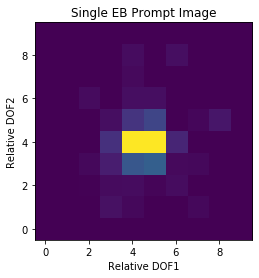

In [49]:
##-- Cell for plotting a single image. Can be skipped.

# # (X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_test_EB_Prompts_arr[2], cmap = "viridis", vmin=0, vmax=4)
# # plt.imshow(SigEB_rechits_arr, cmap = "viridis", vmin=0, vmax=3.75)
# # plt.imshow(SigEB_rechits_arr, cmap = "viridis")
# plt.imshow(SigEB_rechits_arr, cmap = "viridis")
plt.gca().invert_yaxis()
plt.title("Single EB Prompt Image")
plt.xlabel("Relative DOF1")
plt.ylabel("Relative DOF2")
# # plt.imshow(FakeEB_rechits_arr, cmap = "viridis")
# # plt.imshow(X_train_EB[1])
# # plt.imshow(X_train_EB[2])

Text(0, 0.5, 'Relative DOF2')

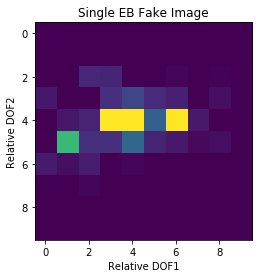

In [42]:
##-- Cell for plotting a single image. Can be skipped.

# # (X_train_mnist, y_train_mnist), (X_test_mnist, y_test_mnist) = mnist.load_data()

import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_test_EB_Fakes_arr[3], cmap = "viridis", vmin=0, vmax=2)
# # plt.imshow(SigEB_rechits_arr, cmap = "viridis", vmin=0, vmax=3.75)
# # plt.imshow(SigEB_rechits_arr, cmap = "viridis")
# plt.imshow(SigEB_rechits_arr, cmap = "viridis")
# plt.gca().invert_yaxis()
plt.title("Single EB Fake Image")
plt.xlabel("Relative DOF1")
plt.ylabel("Relative DOF2")
# # plt.imshow(FakeEB_rechits_arr, cmap = "viridis")
# # plt.imshow(X_train_EB[1])
# # plt.imshow(X_train_EB[2])

In [50]:
##-- Reshape and categorize arrays. Format needed for CNN

X_train_EB_reshape = X_train_EB_arr.reshape(len(X_train_EB_arr),int(width),int(width),1)
Y_train_EB_reshape = to_categorical(Y_train_EB_arr)

X_valid_EB_reshape = X_valid_EB_arr.reshape(len(X_valid_EB_arr),int(width),int(width),1)
Y_valid_EB_reshape = to_categorical(Y_valid_EB_arr)

X_test_EB_Prompts_reshape = X_test_EB_Prompts_arr.reshape(len(X_test_EB_Prompts_arr),int(width),int(width),1)
Y_test_EB_Prompts_reshape = to_categorical(Y_test_EB_Prompts_arr)

X_test_EB_Fakes_reshape = X_test_EB_Fakes_arr.reshape(len(X_test_EB_Fakes_arr),int(width),int(width),1)
Y_test_EB_Fakes_reshape = to_categorical(Y_test_EB_Fakes_arr)

X_train_EE_reshape = X_train_EE_arr.reshape(len(X_train_EE_arr),int(width),int(width),1)
Y_train_EE_reshape = to_categorical(Y_train_EE_arr)

X_valid_EE_reshape = X_valid_EE_arr.reshape(len(X_valid_EE_arr),int(width),int(width),1)
Y_valid_EE_reshape = to_categorical(Y_valid_EE_arr)

X_test_EE_Prompts_reshape = X_test_EE_Prompts_arr.reshape(len(X_test_EE_Prompts_arr),int(width),int(width),1)
Y_test_EE_Prompts_reshape = to_categorical(Y_test_EE_Prompts_arr)

X_test_EE_Fakes_reshape = X_test_EE_Fakes_arr.reshape(len(X_test_EE_Fakes_arr),int(width),int(width),1)
Y_test_EE_Fakes_reshape = to_categorical(Y_test_EE_Fakes_arr)


In [51]:
##-- Model CNN for EB and EE

# These settings can be played with 

model_EB = Sequential()
model_EB.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(int(width),int(width),1)))
model_EB.add(Conv2D(32, kernel_size=3, activation='relu'))
model_EB.add(Flatten())
model_EB.add(Dense(2, activation='softmax')) # 1? 

model_EE = Sequential()
model_EE.add(Conv2D(64, kernel_size=3, activation='relu', input_shape=(int(width),int(width),1)))
model_EE.add(Conv2D(32, kernel_size=3, activation='relu'))
model_EE.add(Flatten())
model_EE.add(Dense(2, activation='softmax')) # 1? 

# model = Sequential([
#     Dense(16, input_shape=(1,), activation='relu'),
#     Dense(32, activation='relu'),
#     Dense(2, activation='softmax') # output layer. In this example 2 for yes or no 
# ])

W0416 19:15:34.529770 140063099168576 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0416 19:15:34.570426 140063099168576 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0416 19:15:34.578275 140063099168576 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [52]:
##-- Compile CNN Models

# These settings can be played with 

# model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model_EB.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_EE.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W0416 19:15:50.775916 140063099168576 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0416 19:15:50.840259 140063099168576 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [53]:
##-- Train models on training data, validate with validation data, for chosen number of Epochs

nEpochs = 2

model_EB.fit(X_train_EB_reshape, Y_train_EB_reshape, validation_data=(X_valid_EB_reshape, Y_valid_EB_reshape), epochs=nEpochs)

model_EE.fit(X_train_EE_reshape, Y_train_EE_reshape, validation_data=(X_valid_EE_reshape, Y_valid_EE_reshape), epochs=nEpochs)


W0416 19:15:56.458203 140063099168576 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0416 19:15:56.568822 140063099168576 deprecation_wrapper.py:119] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 746 samples, validate on 247 samples
Epoch 1/2
746/746 [==============================] - 1s 1ms/step - loss: 0.7095 - acc: 0.5684 - val_loss: 0.6363 - val_acc: 0.6680
Epoch 2/2
746/746 [==============================] - 0s 369us/step - loss: 0.6404 - acc: 0.6582 - val_loss: 0.6522 - val_acc: 0.6478
Train on 604 samples, validate on 203 samples
Epoch 1/2
604/604 [==============================] - 1s 871us/step - loss: 0.8477 - acc: 0.5646 - val_loss: 0.6618 - val_acc: 0.6158
Epoch 2/2
604/604 [==============================] - 0s 432us/step - loss: 0.6060 - acc: 0.6689 - val_loss: 0.5908 - val_acc: 0.6355


2020-04-16 19:15:56.899737: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2020-04-16 19:15:56.914875: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400070000 Hz
2020-04-16 19:15:56.917653: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x350e4890 executing computations on platform Host. Devices:
2020-04-16 19:15:56.917695: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2020-04-16 19:15:57.144527: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via 

In [54]:
##-- Apply CNN output weights on test images 

EB_Prediction_Prompts = model_EB.predict(X_test_EB_Prompts_reshape)
EB_Prediction_Fakes = model_EB.predict(X_test_EB_Fakes_reshape)
EE_Prediction_Prompts = model_EE.predict(X_test_EE_Prompts_reshape)
EE_Prediction_Fakes = model_EE.predict(X_test_EE_Fakes_reshape)

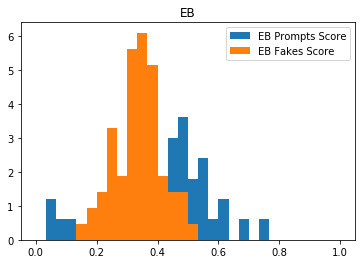

In [55]:
##-- Plot EB Results on Test data 

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(EB_Prediction_Prompts[:,1], density=True, range=[0,1], bins=30, label="EB Prompts Score" )
plt.hist(EB_Prediction_Fakes[:,1], density=True, range=[0,1], bins=30, label="EB Fakes Score" )
plt.title("EB")
leg = plt.legend()


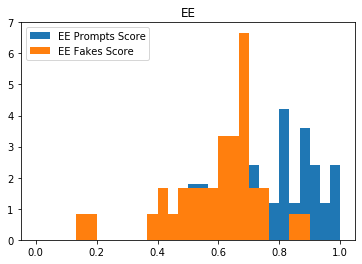

In [56]:
##-- Plot EE Results on Test data 

import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(EE_Prediction_Prompts[:,1], density=True, range=[0,1], bins=30, label="EE Prompts Score" )
plt.hist(EE_Prediction_Fakes[:,1], density=True, range=[0,1], bins=30, label="EE Fakes Score" )
plt.title("EE")
leg = plt.legend()

In [57]:
##--Plot ROC Curves 

##-- Options
####################################
# outputLocation = "/eos/user/<letter>/<lxplusName>/www/<outputDirectory>/"
outputLocation = "/eos/user/a/atishelm/www/test/" # Output location for plots 
n = 20 # Number of points 
####################################

from array import array 

###-- EB 

c10 = ROOT.TCanvas('c10','c10',800,600)
c11 = ROOT.TCanvas('c11','c11',800,600)

EB_Prompts_h = ROOT.TH1F("EB_Prompts_h","EB_Prompts_h",n,0,1)
EB_Fakes_h = ROOT.TH1F("EB_Fakes_h","EB_Fakes_h",n,0,1)

ROC_EB_x, ROC_EB_y = array( 'd' ), array( 'd' )

for item in range(0,n):
    IDcut = item / 10. 

for item in EB_Prediction_Prompts[:,1]:
    EB_Prompts_h.Fill(item)

for item in EB_Prediction_Fakes[:,1]:
    EB_Fakes_h.Fill(item) 
    
EB_Prompts_h.Scale(1/EB_Prompts_h.Integral(1,n))
EB_Fakes_h.Scale(1/EB_Fakes_h.Integral(1,n))
    
for IDcut_i in range(0,n):
#     IDcut = IDcut_i / 10.
    PromptInt = EB_Prompts_h.Integral(IDcut_i,n)
    FakeInt = EB_Fakes_h.Integral(IDcut_i,n)
    ROC_EB_y.append(PromptInt)
    ROC_EB_x.append(FakeInt)
#     print('ROC_x val:',PromptInt)
#     print('ROC_y val:',FakeInt)
    
ROC_g = ROOT.TGraph(n,ROC_EB_x,ROC_EB_y)  
    
ROC_g.SetLineColor( 2 )
ROC_g.SetLineWidth( 4 )
ROC_g.SetMarkerColor( 4 )
ROC_g.SetMarkerStyle( 21 )
ROC_g.SetTitle( 'Photon CNN ROC: EB' )
ROC_g.GetYaxis().SetTitle( 'True Positive Rate' )
ROC_g.GetXaxis().SetTitle( 'False Positive Rate' )

c10.cd()
ROC_g.Draw( 'ACP' )    
c10.SaveAs(outputLocation + "ROC_EB_g.png")    
    
c11.cd()
    
    
    
    
###-- EE 
    
c10 = ROOT.TCanvas('c10','c10',800,600)

EE_Prompts_h = ROOT.TH1F("EE_Prompts_h","EE_Prompts_h",10,0,1)
EE_Fakes_h = ROOT.TH1F("EE_Fakes_h","EE_Fakes_h",10,0,1)

ROC_EE_x, ROC_EE_y = array( 'd' ), array( 'd' )

for item in range(0,n):
    IDcut = item / 10. 

for item in EE_Prediction_Prompts[:,1]:
    EE_Prompts_h.Fill(item)

for item in EE_Prediction_Fakes[:,1]:
    EE_Fakes_h.Fill(item) 
    
EE_Prompts_h.Scale(1/EE_Prompts_h.Integral(1,n))
EE_Fakes_h.Scale(1/EE_Fakes_h.Integral(1,n))
    
for IDcut_i in range(0,n):
    PromptInt = EE_Prompts_h.Integral(IDcut_i,n)
    FakeInt = EE_Fakes_h.Integral(IDcut_i,n)
    ROC_EE_y.append(PromptInt)
    ROC_EE_x.append(FakeInt)
#     print('ROC_x val:',PromptInt)
#     print('ROC_y val:',FakeInt)
    
ROC_EE_g = ROOT.TGraph(n,ROC_EE_x,ROC_EE_y)  
    
ROC_EE_g.SetLineColor( 2 )
ROC_EE_g.SetLineWidth( 4 )
ROC_EE_g.SetMarkerColor( 4 )
ROC_EE_g.SetMarkerStyle( 21 )
ROC_EE_g.SetTitle( 'Photon CNN ROC: EE' )
ROC_EE_g.GetYaxis().SetTitle( 'True Positive Rate' )
ROC_EE_g.GetXaxis().SetTitle( 'False Positive Rate' )

c10.cd()
ROC_EE_g.Draw( 'ACP' )    
c10.SaveAs(outputLocation + "ROC_EE_g.png")  
    

Info in <TCanvas::Print>: png file /eos/user/a/atishelm/www/test/ROC_EB_g.png has been created
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c10
Info in <TCanvas::Print>: png file /eos/user/a/atishelm/www/test/ROC_EE_g.png has been created
